<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:18] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


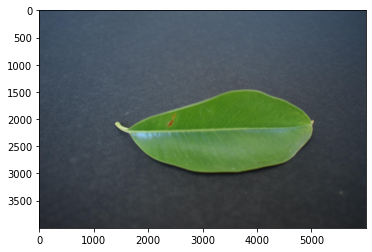

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

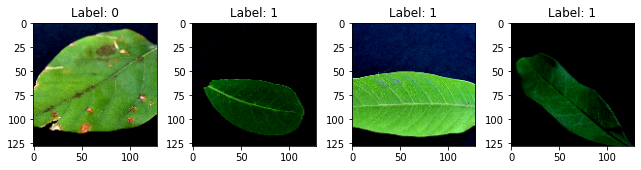

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:24] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:26] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2613286370240335 samples/sec                   batch loss = 1.1606955528259277 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2638582110515848 samples/sec                   batch loss = 0.5534467697143555 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.225412792700762 samples/sec                   batch loss = 0.8375914692878723 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2617239091534382 samples/sec                   batch loss = 0.3374926745891571 | accuracy = 0.6375


Epoch[1] Batch[25] Speed: 1.2685330504292291 samples/sec                   batch loss = 1.1888880729675293 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2628554120301594 samples/sec                   batch loss = 0.9964743852615356 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.2656949776991746 samples/sec                   batch loss = 0.5391184687614441 | accuracy = 0.5285714285714286


Epoch[1] Batch[40] Speed: 1.2600463500621604 samples/sec                   batch loss = 0.5856499671936035 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.2653073291400818 samples/sec                   batch loss = 0.25266918540000916 | accuracy = 0.5833333333333334


Epoch[1] Batch[50] Speed: 1.2672170332562958 samples/sec                   batch loss = 0.5841875076293945 | accuracy = 0.585


Epoch[1] Batch[55] Speed: 1.2655987354585694 samples/sec                   batch loss = 1.3107928037643433 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.267320988777136 samples/sec                   batch loss = 1.2433078289031982 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.263851165644181 samples/sec                   batch loss = 1.179168701171875 | accuracy = 0.6076923076923076


Epoch[1] Batch[70] Speed: 1.272418802341457 samples/sec                   batch loss = 0.32714444398880005 | accuracy = 0.6107142857142858


Epoch[1] Batch[75] Speed: 1.2684550768397012 samples/sec                   batch loss = 1.003708839416504 | accuracy = 0.6


Epoch[1] Batch[80] Speed: 1.2646085202476842 samples/sec                   batch loss = 0.7134655714035034 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.2706062653404022 samples/sec                   batch loss = 0.46953916549682617 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.2684065519911465 samples/sec                   batch loss = 0.6163705587387085 | accuracy = 0.5972222222222222


Epoch[1] Batch[95] Speed: 1.2657131202372753 samples/sec                   batch loss = 0.7130395174026489 | accuracy = 0.6


Epoch[1] Batch[100] Speed: 1.2733077319073969 samples/sec                   batch loss = 0.7874414324760437 | accuracy = 0.6025


Epoch[1] Batch[105] Speed: 1.2682153657012218 samples/sec                   batch loss = 0.4478899836540222 | accuracy = 0.6047619047619047


Epoch[1] Batch[110] Speed: 1.2626236088233653 samples/sec                   batch loss = 0.5870751142501831 | accuracy = 0.615909090909091


Epoch[1] Batch[115] Speed: 1.2635419115907107 samples/sec                   batch loss = 0.47603970766067505 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.2694466208616493 samples/sec                   batch loss = 0.7736306190490723 | accuracy = 0.625


Epoch[1] Batch[125] Speed: 1.263659732005452 samples/sec                   batch loss = 0.6323397755622864 | accuracy = 0.62


Epoch[1] Batch[130] Speed: 1.2702584958279697 samples/sec                   batch loss = 0.8259814381599426 | accuracy = 0.6134615384615385


Epoch[1] Batch[135] Speed: 1.2716512956775177 samples/sec                   batch loss = 0.3465665876865387 | accuracy = 0.6185185185185185


Epoch[1] Batch[140] Speed: 1.259642481471999 samples/sec                   batch loss = 0.6416341662406921 | accuracy = 0.6160714285714286


Epoch[1] Batch[145] Speed: 1.2644147606860023 samples/sec                   batch loss = 0.3281572461128235 | accuracy = 0.6172413793103448


Epoch[1] Batch[150] Speed: 1.2682605203527981 samples/sec                   batch loss = 1.732344388961792 | accuracy = 0.6166666666666667


Epoch[1] Batch[155] Speed: 1.2633091904353282 samples/sec                   batch loss = 0.5872458219528198 | accuracy = 0.6161290322580645


Epoch[1] Batch[160] Speed: 1.2663310408032316 samples/sec                   batch loss = 0.36475980281829834 | accuracy = 0.6203125


Epoch[1] Batch[165] Speed: 1.2625068365780177 samples/sec                   batch loss = 0.5574054718017578 | accuracy = 0.6227272727272727


Epoch[1] Batch[170] Speed: 1.25866741569055 samples/sec                   batch loss = 0.18574149906635284 | accuracy = 0.625


Epoch[1] Batch[175] Speed: 1.2675407299027648 samples/sec                   batch loss = 0.6093275547027588 | accuracy = 0.62


Epoch[1] Batch[180] Speed: 1.255457412914006 samples/sec                   batch loss = 0.5846118927001953 | accuracy = 0.6208333333333333


Epoch[1] Batch[185] Speed: 1.2619990478525194 samples/sec                   batch loss = 0.7224565148353577 | accuracy = 0.6148648648648649


Epoch[1] Batch[190] Speed: 1.2585909334307965 samples/sec                   batch loss = 0.5690872073173523 | accuracy = 0.6105263157894737


Epoch[1] Batch[195] Speed: 1.2630100898730359 samples/sec                   batch loss = 0.5510473847389221 | accuracy = 0.6166666666666667


Epoch[1] Batch[200] Speed: 1.2638516416827474 samples/sec                   batch loss = 0.3699677586555481 | accuracy = 0.62


Epoch[1] Batch[205] Speed: 1.2655675171615444 samples/sec                   batch loss = 0.30970776081085205 | accuracy = 0.6231707317073171


Epoch[1] Batch[210] Speed: 1.262318564263354 samples/sec                   batch loss = 0.5433768630027771 | accuracy = 0.6285714285714286


Epoch[1] Batch[215] Speed: 1.2664802613700186 samples/sec                   batch loss = 0.6604462265968323 | accuracy = 0.6267441860465116


Epoch[1] Batch[220] Speed: 1.2703398654882094 samples/sec                   batch loss = 0.4990544319152832 | accuracy = 0.6306818181818182


Epoch[1] Batch[225] Speed: 1.260987917235101 samples/sec                   batch loss = 0.8006740212440491 | accuracy = 0.63


Epoch[1] Batch[230] Speed: 1.2622839936144015 samples/sec                   batch loss = 0.4932202398777008 | accuracy = 0.6282608695652174


Epoch[1] Batch[235] Speed: 1.2652577089454538 samples/sec                   batch loss = 0.4510047137737274 | accuracy = 0.6276595744680851


Epoch[1] Batch[240] Speed: 1.2628085503164057 samples/sec                   batch loss = 0.7982805967330933 | accuracy = 0.625


Epoch[1] Batch[245] Speed: 1.2708469775107596 samples/sec                   batch loss = 0.731151282787323 | accuracy = 0.6255102040816326


Epoch[1] Batch[250] Speed: 1.266206032321989 samples/sec                   batch loss = 0.514502227306366 | accuracy = 0.627


Epoch[1] Batch[255] Speed: 1.267076634227999 samples/sec                   batch loss = 0.2729230523109436 | accuracy = 0.6313725490196078


Epoch[1] Batch[260] Speed: 1.2678746524385207 samples/sec                   batch loss = 1.0582275390625 | accuracy = 0.6269230769230769


Epoch[1] Batch[265] Speed: 1.2571201297431378 samples/sec                   batch loss = 0.5124051570892334 | accuracy = 0.629245283018868


Epoch[1] Batch[270] Speed: 1.2635836886904879 samples/sec                   batch loss = 0.6572708487510681 | accuracy = 0.6277777777777778


Epoch[1] Batch[275] Speed: 1.2654718670150031 samples/sec                   batch loss = 0.34734466671943665 | accuracy = 0.63


Epoch[1] Batch[280] Speed: 1.263279987416306 samples/sec                   batch loss = 0.6987498998641968 | accuracy = 0.63125


Epoch[1] Batch[285] Speed: 1.2634129814709094 samples/sec                   batch loss = 0.974494993686676 | accuracy = 0.6289473684210526


Epoch[1] Batch[290] Speed: 1.2641255185055587 samples/sec                   batch loss = 0.5181641578674316 | accuracy = 0.628448275862069


Epoch[1] Batch[295] Speed: 1.2645802103018733 samples/sec                   batch loss = 0.5418385863304138 | accuracy = 0.6305084745762712


Epoch[1] Batch[300] Speed: 1.2650226384637935 samples/sec                   batch loss = 0.5003839731216431 | accuracy = 0.63


Epoch[1] Batch[305] Speed: 1.2647663928824806 samples/sec                   batch loss = 0.7279220223426819 | accuracy = 0.6303278688524591


Epoch[1] Batch[310] Speed: 1.2598696907355225 samples/sec                   batch loss = 0.29453879594802856 | accuracy = 0.6306451612903226


Epoch[1] Batch[315] Speed: 1.2602907457900017 samples/sec                   batch loss = 0.35678327083587646 | accuracy = 0.6285714285714286


Epoch[1] Batch[320] Speed: 1.2604367469415625 samples/sec                   batch loss = 0.7126109600067139 | accuracy = 0.6265625


Epoch[1] Batch[325] Speed: 1.2698074968766104 samples/sec                   batch loss = 1.0662838220596313 | accuracy = 0.6253846153846154


Epoch[1] Batch[330] Speed: 1.2636537357671316 samples/sec                   batch loss = 0.7693299651145935 | accuracy = 0.6265151515151515


Epoch[1] Batch[335] Speed: 1.264744940482293 samples/sec                   batch loss = 0.3230917453765869 | accuracy = 0.6291044776119403


Epoch[1] Batch[340] Speed: 1.2667248641366924 samples/sec                   batch loss = 0.7912883162498474 | accuracy = 0.6286764705882353


Epoch[1] Batch[345] Speed: 1.2629451528883937 samples/sec                   batch loss = 0.5059219598770142 | accuracy = 0.6304347826086957


Epoch[1] Batch[350] Speed: 1.2642886058596163 samples/sec                   batch loss = 0.326312392950058 | accuracy = 0.6335714285714286


Epoch[1] Batch[355] Speed: 1.2629973491474595 samples/sec                   batch loss = 0.39425963163375854 | accuracy = 0.6352112676056338


Epoch[1] Batch[360] Speed: 1.2590420297144203 samples/sec                   batch loss = 0.504863977432251 | accuracy = 0.6375


Epoch[1] Batch[365] Speed: 1.263465882454829 samples/sec                   batch loss = 0.27892544865608215 | accuracy = 0.6410958904109589


Epoch[1] Batch[370] Speed: 1.2631045123652704 samples/sec                   batch loss = 0.4753696620464325 | accuracy = 0.6425675675675676


Epoch[1] Batch[375] Speed: 1.2701244413704722 samples/sec                   batch loss = 0.3676823377609253 | accuracy = 0.644


Epoch[1] Batch[380] Speed: 1.2629514276203477 samples/sec                   batch loss = 0.4931541383266449 | accuracy = 0.6467105263157895


Epoch[1] Batch[385] Speed: 1.2685316117153136 samples/sec                   batch loss = 0.5199799537658691 | accuracy = 0.6474025974025974


Epoch[1] Batch[390] Speed: 1.2630129423095005 samples/sec                   batch loss = 1.1095242500305176 | accuracy = 0.6493589743589744


Epoch[1] Batch[395] Speed: 1.265372795581834 samples/sec                   batch loss = 1.2644010782241821 | accuracy = 0.65


Epoch[1] Batch[400] Speed: 1.2677277853155533 samples/sec                   batch loss = 1.002849817276001 | accuracy = 0.650625


Epoch[1] Batch[405] Speed: 1.2735202738143403 samples/sec                   batch loss = 0.2929069995880127 | accuracy = 0.6530864197530865


Epoch[1] Batch[410] Speed: 1.2720762128905148 samples/sec                   batch loss = 0.6409396529197693 | accuracy = 0.6548780487804878


Epoch[1] Batch[415] Speed: 1.2724630987039276 samples/sec                   batch loss = 0.4795580506324768 | accuracy = 0.6566265060240963


Epoch[1] Batch[420] Speed: 1.2694751491161989 samples/sec                   batch loss = 1.4653880596160889 | accuracy = 0.656547619047619


Epoch[1] Batch[425] Speed: 1.268301171876447 samples/sec                   batch loss = 0.9835792779922485 | accuracy = 0.6552941176470588


Epoch[1] Batch[430] Speed: 1.2695007007626289 samples/sec                   batch loss = 0.41012054681777954 | accuracy = 0.6569767441860465


Epoch[1] Batch[435] Speed: 1.2629061748895902 samples/sec                   batch loss = 0.5832647681236267 | accuracy = 0.6580459770114943


Epoch[1] Batch[440] Speed: 1.2693581626086112 samples/sec                   batch loss = 0.7750992178916931 | accuracy = 0.6579545454545455


Epoch[1] Batch[445] Speed: 1.2687637664427838 samples/sec                   batch loss = 0.5821318030357361 | accuracy = 0.6584269662921348


Epoch[1] Batch[450] Speed: 1.2688296870106623 samples/sec                   batch loss = 0.2413136065006256 | accuracy = 0.66


Epoch[1] Batch[455] Speed: 1.264525786323746 samples/sec                   batch loss = 0.8642568588256836 | accuracy = 0.6593406593406593


Epoch[1] Batch[460] Speed: 1.2672641270145328 samples/sec                   batch loss = 0.3646436035633087 | accuracy = 0.658695652173913


Epoch[1] Batch[465] Speed: 1.2702481089620654 samples/sec                   batch loss = 0.6000667810440063 | accuracy = 0.6580645161290323


Epoch[1] Batch[470] Speed: 1.2699928185809435 samples/sec                   batch loss = 0.44829246401786804 | accuracy = 0.6606382978723404


Epoch[1] Batch[475] Speed: 1.2642862240242336 samples/sec                   batch loss = 0.39347749948501587 | accuracy = 0.6610526315789473


Epoch[1] Batch[480] Speed: 1.263912768013934 samples/sec                   batch loss = 1.0272003412246704 | accuracy = 0.6625


Epoch[1] Batch[485] Speed: 1.2698342152374964 samples/sec                   batch loss = 0.4115438461303711 | accuracy = 0.6628865979381443


Epoch[1] Batch[490] Speed: 1.265404004272918 samples/sec                   batch loss = 0.18519197404384613 | accuracy = 0.664795918367347


Epoch[1] Batch[495] Speed: 1.2710891291193096 samples/sec                   batch loss = 0.6138812303543091 | accuracy = 0.6651515151515152


Epoch[1] Batch[500] Speed: 1.271117057107553 samples/sec                   batch loss = 0.179051473736763 | accuracy = 0.6665


Epoch[1] Batch[505] Speed: 1.2657507437896816 samples/sec                   batch loss = 0.892568051815033 | accuracy = 0.6663366336633664


Epoch[1] Batch[510] Speed: 1.2747840371769865 samples/sec                   batch loss = 1.1036452054977417 | accuracy = 0.6651960784313725


Epoch[1] Batch[515] Speed: 1.2702646510879223 samples/sec                   batch loss = 0.4373283386230469 | accuracy = 0.6640776699029126


Epoch[1] Batch[520] Speed: 1.2679104881985783 samples/sec                   batch loss = 0.5828155875205994 | accuracy = 0.6639423076923077


Epoch[1] Batch[525] Speed: 1.2722519707442688 samples/sec                   batch loss = 0.7502717971801758 | accuracy = 0.6633333333333333


Epoch[1] Batch[530] Speed: 1.270476851675157 samples/sec                   batch loss = 0.35723140835762024 | accuracy = 0.664622641509434


Epoch[1] Batch[535] Speed: 1.269453920898989 samples/sec                   batch loss = 0.4278982877731323 | accuracy = 0.6654205607476635


Epoch[1] Batch[540] Speed: 1.2707024045254813 samples/sec                   batch loss = 0.5600008964538574 | accuracy = 0.6666666666666666


Epoch[1] Batch[545] Speed: 1.2649276428783613 samples/sec                   batch loss = 0.47887149453163147 | accuracy = 0.6678899082568808


Epoch[1] Batch[550] Speed: 1.272573997894064 samples/sec                   batch loss = 0.36606892943382263 | accuracy = 0.6690909090909091


Epoch[1] Batch[555] Speed: 1.2800841852239733 samples/sec                   batch loss = 0.6760482788085938 | accuracy = 0.6702702702702703


Epoch[1] Batch[560] Speed: 1.2594201757310297 samples/sec                   batch loss = 0.5835805535316467 | accuracy = 0.671875


Epoch[1] Batch[565] Speed: 1.2707630403210792 samples/sec                   batch loss = 0.2975449860095978 | accuracy = 0.6738938053097345


Epoch[1] Batch[570] Speed: 1.2689959101749742 samples/sec                   batch loss = 0.3791525661945343 | accuracy = 0.6741228070175439


Epoch[1] Batch[575] Speed: 1.2678203277564668 samples/sec                   batch loss = 0.9271590113639832 | accuracy = 0.6752173913043479


Epoch[1] Batch[580] Speed: 1.268411826251364 samples/sec                   batch loss = 0.23181435465812683 | accuracy = 0.6767241379310345


Epoch[1] Batch[585] Speed: 1.2728998579775546 samples/sec                   batch loss = 0.7578883171081543 | accuracy = 0.6760683760683761


Epoch[1] Batch[590] Speed: 1.2661636038610964 samples/sec                   batch loss = 0.49752163887023926 | accuracy = 0.676271186440678


Epoch[1] Batch[595] Speed: 1.2685842707707868 samples/sec                   batch loss = 0.38253942131996155 | accuracy = 0.676890756302521


Epoch[1] Batch[600] Speed: 1.2714289709136233 samples/sec                   batch loss = 0.44389811158180237 | accuracy = 0.6791666666666667


Epoch[1] Batch[605] Speed: 1.2663697525625222 samples/sec                   batch loss = 0.9167532920837402 | accuracy = 0.6776859504132231


Epoch[1] Batch[610] Speed: 1.2687469755441336 samples/sec                   batch loss = 0.49148863554000854 | accuracy = 0.6766393442622951


Epoch[1] Batch[615] Speed: 1.2735460852341076 samples/sec                   batch loss = 0.5182989239692688 | accuracy = 0.6776422764227642


Epoch[1] Batch[620] Speed: 1.2694921514130437 samples/sec                   batch loss = 0.6152826547622681 | accuracy = 0.6790322580645162


Epoch[1] Batch[625] Speed: 1.2738992363764507 samples/sec                   batch loss = 0.6632022261619568 | accuracy = 0.68


Epoch[1] Batch[630] Speed: 1.274762631039117 samples/sec                   batch loss = 0.5526044964790344 | accuracy = 0.678968253968254


Epoch[1] Batch[635] Speed: 1.2678096933106802 samples/sec                   batch loss = 0.5534602999687195 | accuracy = 0.6795275590551181


Epoch[1] Batch[640] Speed: 1.2691555522741322 samples/sec                   batch loss = 0.5081430077552795 | accuracy = 0.6796875


Epoch[1] Batch[645] Speed: 1.2699472521100859 samples/sec                   batch loss = 0.372624933719635 | accuracy = 0.6810077519379845


Epoch[1] Batch[650] Speed: 1.2728479022861123 samples/sec                   batch loss = 0.3471629321575165 | accuracy = 0.6823076923076923


Epoch[1] Batch[655] Speed: 1.2737140300181766 samples/sec                   batch loss = 1.3865902423858643 | accuracy = 0.682824427480916


Epoch[1] Batch[660] Speed: 1.2668158253817634 samples/sec                   batch loss = 0.49932634830474854 | accuracy = 0.6833333333333333


Epoch[1] Batch[665] Speed: 1.2700739619112924 samples/sec                   batch loss = 0.6239031553268433 | accuracy = 0.6842105263157895


Epoch[1] Batch[670] Speed: 1.2757600871919124 samples/sec                   batch loss = 0.5091055035591125 | accuracy = 0.6850746268656717


Epoch[1] Batch[675] Speed: 1.2639050554873317 samples/sec                   batch loss = 0.4911354184150696 | accuracy = 0.6851851851851852


Epoch[1] Batch[680] Speed: 1.2699361013198702 samples/sec                   batch loss = 0.47384926676750183 | accuracy = 0.6860294117647059


Epoch[1] Batch[685] Speed: 1.2712021005743785 samples/sec                   batch loss = 0.08655498921871185 | accuracy = 0.6864963503649635


Epoch[1] Batch[690] Speed: 1.2689822805398774 samples/sec                   batch loss = 0.5075545907020569 | accuracy = 0.6869565217391305


Epoch[1] Batch[695] Speed: 1.2660756980815469 samples/sec                   batch loss = 0.16195893287658691 | accuracy = 0.6884892086330935


Epoch[1] Batch[700] Speed: 1.2692644352855964 samples/sec                   batch loss = 0.38975587487220764 | accuracy = 0.6896428571428571


Epoch[1] Batch[705] Speed: 1.2651974065634672 samples/sec                   batch loss = 0.8740525245666504 | accuracy = 0.6897163120567376


Epoch[1] Batch[710] Speed: 1.269611564554191 samples/sec                   batch loss = 0.4894731342792511 | accuracy = 0.6911971830985916


Epoch[1] Batch[715] Speed: 1.2707102964760644 samples/sec                   batch loss = 0.3153626620769501 | accuracy = 0.6916083916083916


Epoch[1] Batch[720] Speed: 1.2659367936166277 samples/sec                   batch loss = 0.6646881699562073 | accuracy = 0.6920138888888889


Epoch[1] Batch[725] Speed: 1.2729632148944718 samples/sec                   batch loss = 0.5289614796638489 | accuracy = 0.6927586206896552


Epoch[1] Batch[730] Speed: 1.2695199132043051 samples/sec                   batch loss = 0.2201104313135147 | accuracy = 0.6945205479452055


Epoch[1] Batch[735] Speed: 1.275803452297793 samples/sec                   batch loss = 0.4457043409347534 | accuracy = 0.6948979591836735


Epoch[1] Batch[740] Speed: 1.2709859988039538 samples/sec                   batch loss = 0.4118351340293884 | accuracy = 0.6952702702702702


Epoch[1] Batch[745] Speed: 1.2711943951482323 samples/sec                   batch loss = 0.8778344392776489 | accuracy = 0.6953020134228188


Epoch[1] Batch[750] Speed: 1.2763681467893482 samples/sec                   batch loss = 0.723560094833374 | accuracy = 0.6946666666666667


Epoch[1] Batch[755] Speed: 1.2668258692222438 samples/sec                   batch loss = 0.8374372720718384 | accuracy = 0.6960264900662252


Epoch[1] Batch[760] Speed: 1.2713831086383145 samples/sec                   batch loss = 0.3580099046230316 | accuracy = 0.6967105263157894


Epoch[1] Batch[765] Speed: 1.2765688899669916 samples/sec                   batch loss = 0.33574554324150085 | accuracy = 0.6957516339869281


Epoch[1] Batch[770] Speed: 1.2704993648720877 samples/sec                   batch loss = 0.3922491669654846 | accuracy = 0.6964285714285714


Epoch[1] Batch[775] Speed: 1.2731940960434507 samples/sec                   batch loss = 0.46776580810546875 | accuracy = 0.6958064516129032


Epoch[1] Batch[780] Speed: 1.273156898232993 samples/sec                   batch loss = 0.3477786183357239 | accuracy = 0.6971153846153846


Epoch[1] Batch[785] Speed: 1.2681669550499297 samples/sec                   batch loss = 0.19908341765403748 | accuracy = 0.6977707006369427


[Epoch 1] training: accuracy=0.6982868020304569
[Epoch 1] time cost: 649.1884188652039
[Epoch 1] validation: validation accuracy=0.7333333333333333


Epoch[2] Batch[5] Speed: 1.269967150989482 samples/sec                   batch loss = 0.3828577995300293 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.265186243620137 samples/sec                   batch loss = 0.4907277822494507 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.267379004520867 samples/sec                   batch loss = 0.3326629400253296 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2726347159084574 samples/sec                   batch loss = 0.2227349430322647 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.269657395191801 samples/sec                   batch loss = 0.36835917830467224 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2704646333082807 samples/sec                   batch loss = 2.8433549404144287 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2701704052061704 samples/sec                   batch loss = 0.5039441585540771 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2724795055467848 samples/sec                   batch loss = 1.7375637292861938 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2674261103188174 samples/sec                   batch loss = 0.2723170518875122 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.264113326749008 samples/sec                   batch loss = 0.3692489266395569 | accuracy = 0.775


Epoch[2] Batch[55] Speed: 1.2671859264941925 samples/sec                   batch loss = 0.4327000379562378 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.2756574584854004 samples/sec                   batch loss = 0.3411519229412079 | accuracy = 0.75


Epoch[2] Batch[65] Speed: 1.2711485497940291 samples/sec                   batch loss = 0.4294862151145935 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.2699193755017033 samples/sec                   batch loss = 0.4616197943687439 | accuracy = 0.7678571428571429


Epoch[2] Batch[75] Speed: 1.2690835499630635 samples/sec                   batch loss = 0.23086200654506683 | accuracy = 0.7766666666666666


Epoch[2] Batch[80] Speed: 1.2643624472080648 samples/sec                   batch loss = 0.5415553450584412 | accuracy = 0.775


Epoch[2] Batch[85] Speed: 1.2643100427819165 samples/sec                   batch loss = 0.5133751034736633 | accuracy = 0.7764705882352941


Epoch[2] Batch[90] Speed: 1.2622750663368658 samples/sec                   batch loss = 0.3241831660270691 | accuracy = 0.775


Epoch[2] Batch[95] Speed: 1.2638882025160219 samples/sec                   batch loss = 0.6988498568534851 | accuracy = 0.7710526315789473


Epoch[2] Batch[100] Speed: 1.2661355109044206 samples/sec                   batch loss = 0.8120732307434082 | accuracy = 0.7775


Epoch[2] Batch[105] Speed: 1.2685934793607254 samples/sec                   batch loss = 0.43943700194358826 | accuracy = 0.7714285714285715


Epoch[2] Batch[110] Speed: 1.272966691981005 samples/sec                   batch loss = 0.2740500569343567 | accuracy = 0.775


Epoch[2] Batch[115] Speed: 1.267396142200666 samples/sec                   batch loss = 0.21328867971897125 | accuracy = 0.782608695652174


Epoch[2] Batch[120] Speed: 1.2713594080029063 samples/sec                   batch loss = 0.3510146737098694 | accuracy = 0.7875


Epoch[2] Batch[125] Speed: 1.2684250600428266 samples/sec                   batch loss = 1.141119122505188 | accuracy = 0.786


Epoch[2] Batch[130] Speed: 1.2700384844639738 samples/sec                   batch loss = 0.7247811555862427 | accuracy = 0.7807692307692308


Epoch[2] Batch[135] Speed: 1.26574596910328 samples/sec                   batch loss = 0.6874195337295532 | accuracy = 0.7833333333333333


Epoch[2] Batch[140] Speed: 1.2591460657426843 samples/sec                   batch loss = 0.8912738561630249 | accuracy = 0.7821428571428571


Epoch[2] Batch[145] Speed: 1.2671753026883832 samples/sec                   batch loss = 0.7010183334350586 | accuracy = 0.7775862068965518


Epoch[2] Batch[150] Speed: 1.2688919676095993 samples/sec                   batch loss = 0.11990030109882355 | accuracy = 0.7766666666666666


Epoch[2] Batch[155] Speed: 1.2680466633955005 samples/sec                   batch loss = 0.9794187545776367 | accuracy = 0.7693548387096775


Epoch[2] Batch[160] Speed: 1.2636048162027345 samples/sec                   batch loss = 0.28906574845314026 | accuracy = 0.7671875


Epoch[2] Batch[165] Speed: 1.266566310992872 samples/sec                   batch loss = 0.34108778834342957 | accuracy = 0.7666666666666667


Epoch[2] Batch[170] Speed: 1.267537761214282 samples/sec                   batch loss = 0.5849776268005371 | accuracy = 0.7691176470588236


Epoch[2] Batch[175] Speed: 1.2712021005743785 samples/sec                   batch loss = 0.692247211933136 | accuracy = 0.7657142857142857


Epoch[2] Batch[180] Speed: 1.2618144382745502 samples/sec                   batch loss = 0.44883453845977783 | accuracy = 0.7652777777777777


Epoch[2] Batch[185] Speed: 1.2650877892662487 samples/sec                   batch loss = 0.49913015961647034 | accuracy = 0.7648648648648648


Epoch[2] Batch[190] Speed: 1.2688105914107386 samples/sec                   batch loss = 0.4991927146911621 | accuracy = 0.7671052631578947


Epoch[2] Batch[195] Speed: 1.2698796774787842 samples/sec                   batch loss = 0.6095379590988159 | accuracy = 0.7705128205128206


Epoch[2] Batch[200] Speed: 1.2669148359050384 samples/sec                   batch loss = 0.3383410573005676 | accuracy = 0.77


Epoch[2] Batch[205] Speed: 1.2657686014361238 samples/sec                   batch loss = 0.3610105812549591 | accuracy = 0.7658536585365854


Epoch[2] Batch[210] Speed: 1.268911929403511 samples/sec                   batch loss = 0.5379584431648254 | accuracy = 0.7666666666666667


Epoch[2] Batch[215] Speed: 1.2670261096757574 samples/sec                   batch loss = 0.2390385866165161 | accuracy = 0.7662790697674419


Epoch[2] Batch[220] Speed: 1.2681853602482185 samples/sec                   batch loss = 0.3699447512626648 | accuracy = 0.7647727272727273


Epoch[2] Batch[225] Speed: 1.2717062383524442 samples/sec                   batch loss = 0.3336639106273651 | accuracy = 0.7677777777777778


Epoch[2] Batch[230] Speed: 1.2727179350631665 samples/sec                   batch loss = 0.3600858449935913 | accuracy = 0.7706521739130435


Epoch[2] Batch[235] Speed: 1.2657308813310153 samples/sec                   batch loss = 0.27586278319358826 | accuracy = 0.7712765957446809


Epoch[2] Batch[240] Speed: 1.264464028884608 samples/sec                   batch loss = 1.0246620178222656 | accuracy = 0.771875


Epoch[2] Batch[245] Speed: 1.2646691478296055 samples/sec                   batch loss = 0.29193612933158875 | accuracy = 0.7704081632653061


Epoch[2] Batch[250] Speed: 1.267161329305136 samples/sec                   batch loss = 0.6718237400054932 | accuracy = 0.769


Epoch[2] Batch[255] Speed: 1.2670710839854835 samples/sec                   batch loss = 0.6778420805931091 | accuracy = 0.7676470588235295


Epoch[2] Batch[260] Speed: 1.267019985761407 samples/sec                   batch loss = 0.2337699830532074 | accuracy = 0.7692307692307693


Epoch[2] Batch[265] Speed: 1.2684756003236586 samples/sec                   batch loss = 0.37153518199920654 | accuracy = 0.769811320754717


Epoch[2] Batch[270] Speed: 1.2715184889610394 samples/sec                   batch loss = 0.6416662335395813 | accuracy = 0.7703703703703704


Epoch[2] Batch[275] Speed: 1.2664258649187794 samples/sec                   batch loss = 0.5565680861473083 | accuracy = 0.77


Epoch[2] Batch[280] Speed: 1.2694548814364683 samples/sec                   batch loss = 0.36277827620506287 | accuracy = 0.76875


Epoch[2] Batch[285] Speed: 1.2640500857858317 samples/sec                   batch loss = 1.1333370208740234 | accuracy = 0.769298245614035


Epoch[2] Batch[290] Speed: 1.2650126231961436 samples/sec                   batch loss = 0.921630322933197 | accuracy = 0.7689655172413793


Epoch[2] Batch[295] Speed: 1.2615751431764455 samples/sec                   batch loss = 0.41920900344848633 | accuracy = 0.7694915254237288


Epoch[2] Batch[300] Speed: 1.2680899849315632 samples/sec                   batch loss = 0.43377482891082764 | accuracy = 0.7716666666666666


Epoch[2] Batch[305] Speed: 1.2695679468527272 samples/sec                   batch loss = 0.31303223967552185 | accuracy = 0.7729508196721312


Epoch[2] Batch[310] Speed: 1.2711678121450767 samples/sec                   batch loss = 1.8589563369750977 | accuracy = 0.7725806451612903


Epoch[2] Batch[315] Speed: 1.2667520267997998 samples/sec                   batch loss = 0.5288677215576172 | accuracy = 0.773015873015873


Epoch[2] Batch[320] Speed: 1.270303411360926 samples/sec                   batch loss = 0.3349243700504303 | accuracy = 0.775


Epoch[2] Batch[325] Speed: 1.273302610126697 samples/sec                   batch loss = 0.485678493976593 | accuracy = 0.7730769230769231


Epoch[2] Batch[330] Speed: 1.2729537495884786 samples/sec                   batch loss = 0.6490986943244934 | accuracy = 0.771969696969697


Epoch[2] Batch[335] Speed: 1.2684944940244978 samples/sec                   batch loss = 0.47829270362854004 | accuracy = 0.7723880597014925


Epoch[2] Batch[340] Speed: 1.2686956461243009 samples/sec                   batch loss = 0.6784047484397888 | accuracy = 0.7713235294117647


Epoch[2] Batch[345] Speed: 1.2610667764482932 samples/sec                   batch loss = 0.217817485332489 | accuracy = 0.7702898550724637


Epoch[2] Batch[350] Speed: 1.2678731194030606 samples/sec                   batch loss = 0.6104065179824829 | accuracy = 0.7685714285714286


Epoch[2] Batch[355] Speed: 1.2697567543082964 samples/sec                   batch loss = 0.34982219338417053 | accuracy = 0.7690140845070422


Epoch[2] Batch[360] Speed: 1.2637111306683233 samples/sec                   batch loss = 0.28504830598831177 | accuracy = 0.7708333333333334


Epoch[2] Batch[365] Speed: 1.2635805481746591 samples/sec                   batch loss = 0.47684183716773987 | accuracy = 0.7698630136986301


Epoch[2] Batch[370] Speed: 1.2600813660947767 samples/sec                   batch loss = 0.4364066421985626 | accuracy = 0.7702702702702703


Epoch[2] Batch[375] Speed: 1.270459726786144 samples/sec                   batch loss = 0.5821120738983154 | accuracy = 0.7686666666666667


Epoch[2] Batch[380] Speed: 1.2620357863817733 samples/sec                   batch loss = 0.933273196220398 | accuracy = 0.7690789473684211


Epoch[2] Batch[385] Speed: 1.2652210688382408 samples/sec                   batch loss = 0.3331257700920105 | accuracy = 0.7694805194805194


Epoch[2] Batch[390] Speed: 1.2677881375489726 samples/sec                   batch loss = 0.2656744718551636 | accuracy = 0.7705128205128206


Epoch[2] Batch[395] Speed: 1.2634446644417916 samples/sec                   batch loss = 0.6052606105804443 | accuracy = 0.7708860759493671


Epoch[2] Batch[400] Speed: 1.2675539455234586 samples/sec                   batch loss = 0.27259910106658936 | accuracy = 0.770625


Epoch[2] Batch[405] Speed: 1.2679187287935065 samples/sec                   batch loss = 0.5032214522361755 | accuracy = 0.769753086419753


Epoch[2] Batch[410] Speed: 1.2670575913573239 samples/sec                   batch loss = 0.11740552634000778 | accuracy = 0.7695121951219512


Epoch[2] Batch[415] Speed: 1.2632385157420893 samples/sec                   batch loss = 0.3824048638343811 | accuracy = 0.769277108433735


Epoch[2] Batch[420] Speed: 1.2639109588943058 samples/sec                   batch loss = 0.24275852739810944 | accuracy = 0.7708333333333334


Epoch[2] Batch[425] Speed: 1.2657362288547178 samples/sec                   batch loss = 0.28916987776756287 | accuracy = 0.7705882352941177


Epoch[2] Batch[430] Speed: 1.2676927261805364 samples/sec                   batch loss = 0.23464174568653107 | accuracy = 0.772093023255814


Epoch[2] Batch[435] Speed: 1.2681475918242457 samples/sec                   batch loss = 0.6044756174087524 | accuracy = 0.771264367816092


Epoch[2] Batch[440] Speed: 1.2715073105613401 samples/sec                   batch loss = 0.3630516529083252 | accuracy = 0.772159090909091


Epoch[2] Batch[445] Speed: 1.2688663444965966 samples/sec                   batch loss = 0.7059829235076904 | accuracy = 0.7730337078651686


Epoch[2] Batch[450] Speed: 1.2749872860090168 samples/sec                   batch loss = 0.041948314756155014 | accuracy = 0.7727777777777778


Epoch[2] Batch[455] Speed: 1.2708822113323328 samples/sec                   batch loss = 0.7368186116218567 | accuracy = 0.7725274725274726


Epoch[2] Batch[460] Speed: 1.2724625196466153 samples/sec                   batch loss = 0.4748901128768921 | accuracy = 0.7733695652173913


Epoch[2] Batch[465] Speed: 1.270447027728359 samples/sec                   batch loss = 0.2732788920402527 | accuracy = 0.7741935483870968


Epoch[2] Batch[470] Speed: 1.2721250189277058 samples/sec                   batch loss = 0.3537570536136627 | accuracy = 0.7734042553191489


Epoch[2] Batch[475] Speed: 1.268566045830659 samples/sec                   batch loss = 0.5258387327194214 | accuracy = 0.771578947368421


Epoch[2] Batch[480] Speed: 1.2671671674620253 samples/sec                   batch loss = 0.2781658470630646 | accuracy = 0.7734375


Epoch[2] Batch[485] Speed: 1.2727385967253328 samples/sec                   batch loss = 1.0757551193237305 | accuracy = 0.7737113402061856


Epoch[2] Batch[490] Speed: 1.2671128076893128 samples/sec                   batch loss = 0.2692651152610779 | accuracy = 0.7739795918367347


Epoch[2] Batch[495] Speed: 1.277179373830089 samples/sec                   batch loss = 0.4339505434036255 | accuracy = 0.7742424242424243


Epoch[2] Batch[500] Speed: 1.2732950724866463 samples/sec                   batch loss = 0.6504226922988892 | accuracy = 0.7735


Epoch[2] Batch[505] Speed: 1.2665693707502867 samples/sec                   batch loss = 0.40043386816978455 | accuracy = 0.7727722772277228


Epoch[2] Batch[510] Speed: 1.2606756103324925 samples/sec                   batch loss = 0.5806957483291626 | accuracy = 0.7710784313725491


Epoch[2] Batch[515] Speed: 1.2693233013420366 samples/sec                   batch loss = 0.7029677033424377 | accuracy = 0.7694174757281553


Epoch[2] Batch[520] Speed: 1.2618551521453405 samples/sec                   batch loss = 0.5436368584632874 | accuracy = 0.7682692307692308


Epoch[2] Batch[525] Speed: 1.267950446501448 samples/sec                   batch loss = 0.4381275177001953 | accuracy = 0.768095238095238


Epoch[2] Batch[530] Speed: 1.269703613504078 samples/sec                   batch loss = 1.2394424676895142 | accuracy = 0.7674528301886793


Epoch[2] Batch[535] Speed: 1.2656122925075464 samples/sec                   batch loss = 0.6918662190437317 | accuracy = 0.7677570093457944


Epoch[2] Batch[540] Speed: 1.2704208607734497 samples/sec                   batch loss = 0.2519585192203522 | accuracy = 0.7680555555555556


Epoch[2] Batch[545] Speed: 1.268031712401987 samples/sec                   batch loss = 0.6324607729911804 | accuracy = 0.7674311926605505


Epoch[2] Batch[550] Speed: 1.2696294352268784 samples/sec                   batch loss = 0.36140331625938416 | accuracy = 0.7668181818181818


Epoch[2] Batch[555] Speed: 1.2707566877282706 samples/sec                   batch loss = 0.1589352786540985 | accuracy = 0.7671171171171172


Epoch[2] Batch[560] Speed: 1.2705358302470269 samples/sec                   batch loss = 0.16979043185710907 | accuracy = 0.7674107142857143


Epoch[2] Batch[565] Speed: 1.275019842844067 samples/sec                   batch loss = 0.3624480664730072 | accuracy = 0.7654867256637168


Epoch[2] Batch[570] Speed: 1.2650528759958761 samples/sec                   batch loss = 0.19791828095912933 | accuracy = 0.7666666666666667


Epoch[2] Batch[575] Speed: 1.2769888386508041 samples/sec                   batch loss = 0.3712649643421173 | accuracy = 0.7656521739130435


Epoch[2] Batch[580] Speed: 1.266711570159266 samples/sec                   batch loss = 0.28773170709609985 | accuracy = 0.7655172413793103


Epoch[2] Batch[585] Speed: 1.271799941023567 samples/sec                   batch loss = 0.5988108515739441 | accuracy = 0.7645299145299145


Epoch[2] Batch[590] Speed: 1.2720482427391941 samples/sec                   batch loss = 0.4621284008026123 | accuracy = 0.763135593220339


Epoch[2] Batch[595] Speed: 1.271733518672381 samples/sec                   batch loss = 0.41004082560539246 | accuracy = 0.7621848739495798


Epoch[2] Batch[600] Speed: 1.2686259982635542 samples/sec                   batch loss = 0.33741337060928345 | accuracy = 0.7625


Epoch[2] Batch[605] Speed: 1.266286596887075 samples/sec                   batch loss = 0.4633246660232544 | accuracy = 0.7619834710743801


Epoch[2] Batch[610] Speed: 1.267409546295585 samples/sec                   batch loss = 0.34123530983924866 | accuracy = 0.7622950819672131


Epoch[2] Batch[615] Speed: 1.2728886552764944 samples/sec                   batch loss = 0.6946099400520325 | accuracy = 0.7621951219512195


Epoch[2] Batch[620] Speed: 1.2746868920157246 samples/sec                   batch loss = 0.3935754895210266 | accuracy = 0.7633064516129032


Epoch[2] Batch[625] Speed: 1.2687930316427327 samples/sec                   batch loss = 0.2698376774787903 | accuracy = 0.7648


Epoch[2] Batch[630] Speed: 1.2694009014847267 samples/sec                   batch loss = 0.22723621129989624 | accuracy = 0.765079365079365


Epoch[2] Batch[635] Speed: 1.2629845136017699 samples/sec                   batch loss = 0.2824596166610718 | accuracy = 0.7645669291338583


Epoch[2] Batch[640] Speed: 1.2675866984668647 samples/sec                   batch loss = 0.37478476762771606 | accuracy = 0.765625


Epoch[2] Batch[645] Speed: 1.2664492863679968 samples/sec                   batch loss = 0.39760276675224304 | accuracy = 0.7662790697674419


Epoch[2] Batch[650] Speed: 1.269302174233596 samples/sec                   batch loss = 0.4465392231941223 | accuracy = 0.7669230769230769


Epoch[2] Batch[655] Speed: 1.2687785428012321 samples/sec                   batch loss = 0.19462838768959045 | accuracy = 0.767557251908397


Epoch[2] Batch[660] Speed: 1.2705595001858823 samples/sec                   batch loss = 0.41864174604415894 | accuracy = 0.7670454545454546


Epoch[2] Batch[665] Speed: 1.2655326728691074 samples/sec                   batch loss = 0.3353251814842224 | accuracy = 0.7665413533834586


Epoch[2] Batch[670] Speed: 1.2670380706166953 samples/sec                   batch loss = 1.4679359197616577 | accuracy = 0.766044776119403


Epoch[2] Batch[675] Speed: 1.2650213984696732 samples/sec                   batch loss = 0.10966211557388306 | accuracy = 0.7674074074074074


Epoch[2] Batch[680] Speed: 1.2710747803888043 samples/sec                   batch loss = 0.7803658246994019 | accuracy = 0.768014705882353


Epoch[2] Batch[685] Speed: 1.2762613425819567 samples/sec                   batch loss = 0.34530895948410034 | accuracy = 0.7678832116788321


Epoch[2] Batch[690] Speed: 1.2710794990630863 samples/sec                   batch loss = 0.17581473290920258 | accuracy = 0.7692028985507247


Epoch[2] Batch[695] Speed: 1.2652301332505393 samples/sec                   batch loss = 0.08248081803321838 | accuracy = 0.7694244604316547


Epoch[2] Batch[700] Speed: 1.2659254265812696 samples/sec                   batch loss = 0.5679643750190735 | accuracy = 0.7696428571428572


Epoch[2] Batch[705] Speed: 1.266250661721985 samples/sec                   batch loss = 0.4731401205062866 | accuracy = 0.7702127659574468


Epoch[2] Batch[710] Speed: 1.2682908169957097 samples/sec                   batch loss = 0.2704465389251709 | accuracy = 0.7693661971830986


Epoch[2] Batch[715] Speed: 1.2637998507896218 samples/sec                   batch loss = 0.5585576295852661 | accuracy = 0.7685314685314686


Epoch[2] Batch[720] Speed: 1.2634793938479731 samples/sec                   batch loss = 0.49016934633255005 | accuracy = 0.7680555555555556


Epoch[2] Batch[725] Speed: 1.2639947551334576 samples/sec                   batch loss = 0.17812450230121613 | accuracy = 0.7686206896551724


Epoch[2] Batch[730] Speed: 1.2631378916687803 samples/sec                   batch loss = 0.8902596235275269 | accuracy = 0.7678082191780822


Epoch[2] Batch[735] Speed: 1.2650488696782691 samples/sec                   batch loss = 0.2301943153142929 | accuracy = 0.7687074829931972


Epoch[2] Batch[740] Speed: 1.2643428188596193 samples/sec                   batch loss = 0.1716853678226471 | accuracy = 0.768918918918919


Epoch[2] Batch[745] Speed: 1.268555207035646 samples/sec                   batch loss = 0.9280180931091309 | accuracy = 0.7694630872483221


Epoch[2] Batch[750] Speed: 1.265224980831828 samples/sec                   batch loss = 0.24743375182151794 | accuracy = 0.7696666666666667


Epoch[2] Batch[755] Speed: 1.266712143994256 samples/sec                   batch loss = 0.28830432891845703 | accuracy = 0.7688741721854304


Epoch[2] Batch[760] Speed: 1.2649803846495171 samples/sec                   batch loss = 0.17774105072021484 | accuracy = 0.7694078947368421


Epoch[2] Batch[765] Speed: 1.2686952623685799 samples/sec                   batch loss = 0.6557096838951111 | accuracy = 0.7686274509803922


Epoch[2] Batch[770] Speed: 1.2690901738344464 samples/sec                   batch loss = 0.20289193093776703 | accuracy = 0.7688311688311689


Epoch[2] Batch[775] Speed: 1.2733852401090011 samples/sec                   batch loss = 0.24368546903133392 | accuracy = 0.7687096774193548


Epoch[2] Batch[780] Speed: 1.272021334685529 samples/sec                   batch loss = 0.11225806176662445 | accuracy = 0.7692307692307693


Epoch[2] Batch[785] Speed: 1.268081358725976 samples/sec                   batch loss = 0.3093019723892212 | accuracy = 0.770063694267516


[Epoch 2] training: accuracy=0.7703045685279187
[Epoch 2] time cost: 639.292135477066
[Epoch 2] validation: validation accuracy=0.7744444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8066666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)